
# Semantic segmentation of aerial images with deep networks



This notebook presents a straightforward PyTorch implementation of a Fully Convolutional Network for semantic segmentation of aerial images. More specifically, we aim to automatically perform scene interpretation of images taken from a plane or a satellite by classifying every pixel into several land cover classes.

As a demonstration, we are going to use the [SegNet architecture](http://mi.eng.cam.ac.uk/projects/segnet/) to segment aerial images over the cities of Vaihingen and Potsdam. The images are from the [ISPRS 2D Semantic Labeling dataset](https://www.isprs.org/education/benchmarks/UrbanSemLab/semantic-labeling.aspx). We will train a network to segment roads, buildings, vegetation and cars.

This work is a PyTorch implementation of the baseline presented in "[Beyond RGB: Very High Resolution Urban Remote Sensing With Multimodal Deep Networks](https://hal.archives-ouvertes.fr/hal-01636145) ", Nicolas Audebert, Bertrand Le Saux and Sébastien Lefèvre, ISPRS Journal, 2018.

The original code for this notebook is the [DeepNetsForEO](https://github.com/nshaud/DeepNetsForEO) repository.

#### Agradecimiento: Profesor Ivan Lizarazo.

## GPU

Enable GPU with `Runtime->Change runtime type->Hardware Accelerator->GPU` in the top menu

In [2]:
# imports and stuff
import numpy as np
from skimage import io
from glob import glob
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable

In [3]:
# mount your google drive (follow the link, allow what is needed and get the authorization code)
from google.colab import drive
drive.mount('/content/drive/')

import sys

# data are assumed to be in Vaihingen/ directory, otherwise modify accordingly
FOLDER = '/content/drive/MyDrive/Stack_paramo/'
sys.path.append(FOLDER)

Mounted at /content/drive/


In [4]:
FOLDER


'/content/drive/MyDrive/Stack_paramo/'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Check input files exist in your drive

In [7]:
!ls '/content/drive/MyDrive/Stack_paramo/'

Etiquetas  Imagen


### Note that the top directory contains the orthophoto files:

In [8]:
!ls '/content/drive/MyDrive/Stack_paramo/Imagen'

A15_Imagen.tif		H13_Imagen.tif	L12_Imagen.tif	N8_Imagen.tif	V7_Imagen.tif
A15_Imagen.tif.aux.xml	H14_Imagen.tif	L13_Imagen.tif	O15_Imagen.tif	V8_Imagen.tif
B13_Imagen.tif		I12_Imagen.tif	L15_Imagen.tif	O16_Imagen.tif	V9_Imagen.tif
B14_Imagen.tif		I13_Imagen.tif	L16_Imagen.tif	P7_Imagen.tif	W10_Imagen.tif
B15_Imagen.tif		I14_Imagen.tif	L17_Imagen.tif	P8_Imagen.tif	W4_Imagen.tif
C13_Imagen.tif		I15_Imagen.tif	L7_Imagen.tif	Q7_Imagen.tif	W5_Imagen.tif
C14_Imagen.tif		I9_Imagen.tif	L8_Imagen.tif	Q8_Imagen.tif	W6_Imagen.tif
D13_Imagen.tif		J11_Imagen.tif	M10_Imagen.tif	R7_Imagen.tif	W7_Imagen.tif
D14_Imagen.tif		J12_Imagen.tif	M11_Imagen.tif	R8_Imagen.tif	W8_Imagen.tif
E10_Imagen.tif		J13_Imagen.tif	M12_Imagen.tif	S7_Imagen.tif	W9_Imagen.tif
E11_Imagen.tif		J14_Imagen.tif	M13_Imagen.tif	T10_Imagen.tif	X10_Imagen.tif
E12_Imagen.tif		J8_Imagen.tif	M14_Imagen.tif	T8_Imagen.tif	X3_Imagen.tif
E13_Imagen.tif		J9_Imagen.tif	M15_Imagen.tif	T9_Imagen.tif	X4_Imagen.tif
E14_Imagen.tif		K11_Imagen.tif	

### Note that the *gts_for_participants* directory contains the ground truth files (*i.e. the labels*):

In [9]:
!ls '/content/drive/MyDrive/Stack_paramo/Etiquetas'

A15_Label.tif  G12_Label.tif  K12_Label.tif  M13_Label.tif  Q8_Label.tif   V9_Label.tif
B13_Label.tif  G13_Label.tif  K13_Label.tif  M14_Label.tif  R7_Label.tif   W10_Label.tif
B14_Label.tif  H12_Label.tif  K14_Label.tif  M15_Label.tif  R8_Label.tif   W4_Label.tif
B15_Label.tif  H13_Label.tif  K7_Label.tif   M16_Label.tif  S7_Label.tif   W5_Label.tif
C13_Label.tif  H14_Label.tif  K8_Label.tif   M8_Label.tif   T10_Label.tif  W6_Label.tif
C14_Label.tif  I12_Label.tif  K9_Label.tif   N10_Label.tif  T8_Label.tif   W7_Label.tif
D13_Label.tif  I13_Label.tif  L11_Label.tif  N11_Label.tif  T9_Label.tif   W8_Label.tif
D14_Label.tif  I14_Label.tif  L12_Label.tif  N13_Label.tif  U10_Label.tif  W9_Label.tif
E10_Label.tif  I15_Label.tif  L13_Label.tif  N14_Label.tif  U11_Label.tif  X10_Label.tif
E11_Label.tif  I9_Label.tif   L15_Label.tif  N15_Label.tif  U7_Label.tif   X3_Label.tif
E12_Label.tif  J11_Label.tif  L16_Label.tif  N16_Label.tif  U8_Label.tif   X4_Label.tif
E13_Label.tif  J12_Label.tif  

In order to get started, I have shared *some tiles* from the Vaihingen dataset [here](https://drive.google.com/drive/folders/19ZdB3oejGRBfe8QR-yF1XySYTGsyzU5w?usp=sharing).

If you need the complete dataset, go to [this link](https://drive.google.com/drive/folders/1w3NhvLVA2myVZqOn2pbiDXngNC7NTP_t?usp=sharing)



# Parameters

There are several parameters than can be tuned to use this notebook with different datasets. The default parameters are suitable for the ISPRS dataset, but you can change them to work with your data.

## Examples

*   Binary classification: N_CLASSES = 2
*   Multi-spectral data (e.g. IRRGB): IN_CHANNELS = 4
*  New folder naming convention : DATA_FOLDER = MAIN_FOLDER + 'sentinel2/sentinel2_img_{}.tif'


In [10]:
# Parameters++++
WINDOW_SIZE = (256, 256) # Patch size
STRIDE = 32 # Stride for testing
IN_CHANNELS = 4         # Number of input channels (e.g. RGB)
##FOLDER = "./ISPRS_dataset/" # Replace with your "/path/to/the/ISPRS/dataset/folder/"
BATCH_SIZE = 5 # Number of samples in a mini-batch

LABELS = ['Superficies artificiales','Zona agrícolas','Bosques','Herbazal ','Frailejonal','Herbazal abierto rocoso','Arbustal','Vegetación secundaria','Zon con poca o sin vegetacion','Zonas húmedas','Superficies de agua','Sin Dato'] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

MAIN_FOLDER = '/content/drive/MyDrive/Stack_paramo/'
DATA_FOLDER = MAIN_FOLDER + 'Imagen/{}_Imagen.tif'
LABEL_FOLDER = MAIN_FOLDER + 'Etiquetas/{}_Label.tif'
ERODED_FOLDER = MAIN_FOLDER + 'Etiquetas/{}_Label.tif'




In [11]:
pesos = [0.0239652118666759, 12.9257338757828, 21.9811904556871, 36.6769644809317, 2.74793079813053, 4.7201713173494, 14.8139419091534, 0.226545732724711, 0.139659302044854, 4.6913331882238, 0.0694265496228984, 0.983137178481992]
pesos = torch.tensor(pesos)
print(pesos)

tensor([2.3965e-02, 1.2926e+01, 2.1981e+01, 3.6677e+01, 2.7479e+00, 4.7202e+00,
        1.4814e+01, 2.2655e-01, 1.3966e-01, 4.6913e+00, 6.9427e-02, 9.8314e-01])


In [12]:
#WEIGHTS = pesos


# Visualizing the dataset

First, let's check that we are able to access the dataset and see what's going on. We use scikit-image for image manipulation.

As the ISPRS dataset is stored with a ground truth in the RGB format, we need to define the color palette that can map the label id to its RGB color. We define two helper functions to convert from numeric to colors and vice-versa.


In [13]:
# ISPRS color palette
# Let's define the standard ISPRS color palette
palette = { 0 : (178, 178, 178), #Superficies artificiales
            1 : (152, 251, 152), #Zonas agrícolas
             2 : (0, 128, 0), #Bosques
             3 : (0, 30, 0), #Herbazal
             4 : (255, 255, 0), #Frailejonal
             5 : (0, 64, 0), #Herbazal abierto rocoso
             6 : (20, 128, 20), #Arbustal
             7 : (255, 102, 204), #Vegetación secundaria
             8 : (173, 216, 230), #Zona con poca o sin vegetación
             9 : (0, 168, 181), #Zonas húmedas
             10 : (0, 191, 255), #Superficies de agua
             11 : (255, 255, 255) #Sin Dato
}

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

<ipython-input-14-b06a9a93934a>:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=[c / 255 for c in color], edgecolor='black'))


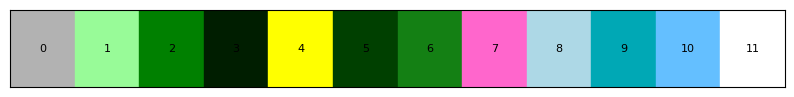

In [14]:
palette2 = {
    0: [(178, 178, 178), 'Superficies artificiales'],
    1: [(152, 251, 152), 'Zonas agrícolas'],
    2: [(0, 128, 0), 'Bosques'],
    3: [(0, 30, 0), 'Herbazal'],
    4: [(255, 255, 0), 'Frailejonal'],
    5: [(0, 64, 0), 'Herbazal abierto rocoso'],
    6: [(20, 128, 20), 'Arbustal'],
    7: [(255, 102, 204), 'Vegetación secundaria'],
    8: [(173, 216, 230), 'Zona con poca o sin vegetación'],
    9: [(0, 168, 181), 'Zonas húmedas'],
    10: [(100, 191, 255), 'Superficies de agua'],
    11: [(255, 255, 255), 'Sin Dato'],
}

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(10, 1))

# Iterar sobre la paleta y dibujar un rectángulo con el color correspondiente
for i, (index, (color, comment)) in enumerate(palette2.items()):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=[c / 255 for c in color], edgecolor='black'))

    # Mostrar el comentario como texto
    ax.text(i + 0.5, 0.5, f"{index}", color='black',
            fontsize=8, ha='center', va='center')

# Configurar los ejes
ax.set_xlim(0, len(palette2))
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])

# Mostrar la paleta de colores
plt.show()

In [15]:
from skimage import exposure, io

In [16]:
#
# We load one tile from the dataset and we display it
print(MAIN_FOLDER+'Imagen/J11_Imagen.tif')

img = io.imread(MAIN_FOLDER+'Imagen/F11_Imagen.tif')
#channel_indices = input("Introduce los índices de los canales (separados por espacios): ")
#channel_indices = list(map(int, channel_indices.split()))
selected_channels = img[:, :, 0:3]  #Seleccionar canales 0, 1 y 2
#selected_channels = img[:, :, channel_indices]
normalized_img = exposure.rescale_intensity(selected_channels)
adapted_img = exposure.equalize_adapthist(normalized_img)
int_img = (adapted_img * 255).astype(float)


print(img.shape)

/content/drive/MyDrive/Stack_paramo/Imagen/J11_Imagen.tif
(511, 511, 5)


# Transformación de imágenes: _Reducción de radiometría_

In [17]:
import numpy as np
range_bands = {
    0 : ( 47.9934  , 6987.96 ),
    1 : ( 169.982  , 6815.96 ),
    2 : ( 124.01  , 6619.95 ),
    3 : ( 977.968  , 6710.95) }
    #,    4 : ( 0.000609179  , 0.877052 )    }

def trf8b (img_path, range_bands):
  # rangei = ( min , max )
  imagen_float32 = np.asarray(io.imread(img_path), dtype='float32')
  imagen_normalizada = np.zeros_like(imagen_float32, dtype='float32')[: , : , [0,1,2,3]]
  for t in range_bands:
    imagen_normalizada[: , : , t] = (imagen_float32[: , : , t] - (range_bands[t][0])) / (range_bands[t][1] - range_bands[t][0])
  imagen_entra_rango = (imagen_normalizada * 255).clip(0, 255).astype(np.uint8)
  return imagen_entra_rango

In [18]:
def trf8_LoadingData (img_path, range_bands):
  # rangei = ( min , max )
  imagen_float32 = np.asarray(io.imread(img_path).transpose((2,0,1)), dtype='float32')
  imagen_normalizada = np.zeros_like(imagen_float32, dtype='float32')[[0,1,2,3] , : , :]
  for t in range_bands:
    imagen_normalizada[t , : , :] = (imagen_float32[t , : , :] - (range_bands[t][0])) / (range_bands[t][1] - range_bands[t][0])
  imagen_entra_rango = (imagen_normalizada * 255).clip(0, 255).astype(np.uint8)
  return imagen_entra_rango

In [19]:
img_path = MAIN_FOLDER+'Imagen/W9_Imagen.tif'
img = trf8b(img_path,range_bands)

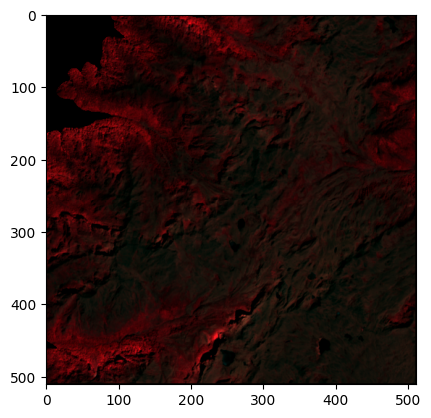

In [20]:

fig = plt.figure()
fig.add_subplot()
plt.imshow(img[:, :, [3,2,1]]);##img)
plt.show()

In [21]:
import plotly.express as px
fig = px.imshow(img[:,:,[3,2,1]], contrast_rescaling='infer')
fig.show()

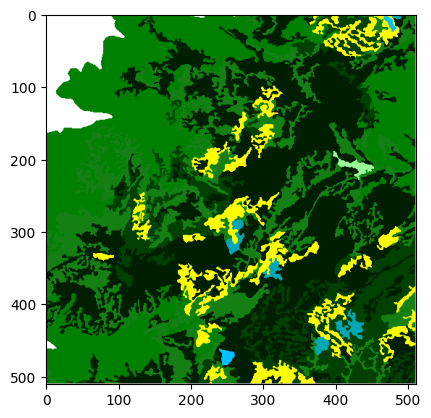

Ground truth in numerical format has shape (511,511) : 
 [[11 11 11 ...  6  6  0]
 [11 11 11 ...  6  6  0]
 [11 11 11 ...  6  6  0]
 ...
 [ 6  6  2 ...  5  5  0]
 [ 6  6  6 ...  5  5  0]
 [ 0  0  0 ...  0  0  0]]


In [22]:
# We load the ground truth
gt = io.imread(MAIN_FOLDER+'Etiquetas/W9_Label.tif')
gt = convert_to_color(gt)
plt.imshow(gt)
plt.show()
# We also check that we can convert the ground truth into an array format
array_gt = convert_from_color(gt)
print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)

In [23]:
# Get unique RGB values
np.unique(gt.reshape(-1, gt.shape[1]), axis=0)

array([[  0,   0,  30, ..., 178, 178, 178],
       [  0,   0,  30, ..., 178, 178, 178],
       [  0,   0,  30, ..., 178, 178, 178],
       ...,
       [255, 255, 255, ..., 128,   0,   0],
       [255, 255, 255, ..., 128,   0,   0],
       [255, 255, 255, ..., 128,   0,   0]], dtype=uint8)

# Utils

We need to define a bunch of utils functions.

In [24]:
# Uso función de pérdida
def CustomLossFunction(input, target):#, weight=None, size_average=True): ############################################### definir funciön de PÉRDIDA
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
      return F.IoUWCELoss(input, target)
    elif dim == 4:
      output = input.view(input.size(0),input.size(1), -1)
      output = torch.transpose(output,1,2).contiguous()
      output = output.view(-1,output.size(2))
      target = target.view(-1)
      return F.IoUWCELoss(input, target)
    else:
      raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

In [25]:
# Utils

def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, size_average=True): ############################################### definir funciön de PÉRDIDA
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
##        return nn.CrossEntropyLoss(output, target,weight)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
##        return nn.CrossEntropyLoss(output, target,weight)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]

def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            y_true= gts,
            y_pred= predictions,
            labels = range(len(label_values)))

    print("Confusion matrix :")
    print(cm)

    print("---")

    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))

    print("---")

    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")

    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy


# Loading the dataset

We define a PyTorch dataset (`torch.utils.data.Dataset)` that loads all the tiles in memory and performs random sampling. Tiles are stored in memory on the fly.

The dataset also performs random data augmentation (horizontal and vertical flips) and normalizes the data in [0, 1].

In [26]:
# Dataset class

class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()

        self.augmentation = augmentation
        self.cache = cache

        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))

        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}


    def __len__(self):
        # Default epoch size is 10 000 samples
        #return 10
        return 10000

    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True

        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))

        return tuple(results)

    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)

        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/255 * np.asarray(trf8_LoadingData(self.data_files[random_idx], range_bands), dtype='float32')
            #---------------->data = 1/255 * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data

        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else:
            # Labels are converted from RGB to their numeric values
            label = np.asarray(convert_from_color(convert_to_color(io.imread(self.label_files[random_idx]))), dtype='int64')

            #label = io.imread(self.label_files[random_idx], dtype='int64') #las etiquetas ya tienen valor numérico
            if self.cache:
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]

        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))


# Network definition

We can now define the Fully Convolutional network based on the SegNet architecture. We could use any other network as drop-in replacement, provided that the output has dimensions (`N_CLASSES, W, H`) where `W` and `H` are the sliding window dimensions (i.e. the network should preserve the spatial dimensions).

### SegNet architecture

![](https://github.com/kulkarnikeerti/SegNet-Semantic-Segmentation/raw/master/SegNet.JPG)

Note that *there are no fully connected layers and hence it is only convolutional*. A decoder upsamples its input using the transferred pool indices from its encoder to produce a sparse feature map(s). It then performs convolution with a trainable filter bank to densify the feature map. The final decoder output feature maps are fed to a soft-max classifier for pixel-wise classification




![](https://drive.google.com/uc?id=19jI3707u9COTNAwxS56F6mEUjdWcsQEJ)

The above figure illustrates the *max pooling* operation as well as the *unpooling* operation.

In [27]:
from google.colab import drive
drive.mount('/content/drive') #

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:

class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)

    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)

        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)

        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)

        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)

        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)

        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)

        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)

        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)

        self.apply(self.weight_init)

    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)

        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)

        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)

        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)

        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)

        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))

        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))

        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))

        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))

        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x))
        return x


We can now instantiate the network using the specified parameters. By default, the weights will be initialized using the [He policy](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) (i.e. zero-mean Gaussian distribution whose standard deviation is `√(2/n) `for a layer with `n` response connections and `b=0`).

In [29]:
# instantiate the network
net = SegNet()

We download and load the pre-trained weights from VGG-16 on ImageNet. This step is optional but it makes the network converge faster. We skip the weights from VGG-16 that have no counterpart in SegNet.


In [30]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))

try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignore missing keys
    pass

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_1_bn.num_batches_tracked
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.7.bias to conv1_2_bn.num_batches_tracked
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping fe


Then, we load the network on GPU.


In [31]:
net.cuda()


SegNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1_1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1_bn): BatchNorm2d(256, eps=1e-05, mom


# Loading the data

We now create a train/test split. If you want to use another dataset, you have to adjust the method to collect all filenames. In our case, we specify a fixed train/test split for the demo.


In [32]:
import os

## Load the datasets
'''if DATASET == 'Potsdam':
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = ["".join(f.split('')[5:7]) for f in all_files]
elif DATASET == 'Vaihingen':
    #all_ids =
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = [f.split('area')[-1].split('.')[0] for f in all_files]'''

all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
#all_ids = ["".join(f.split('/')[6].split('_')[0]) for f in all_files]
all_ids = ['Y4','Y3','X10','X9','X4','X3','W10','W9','W5','W4','V10','V9','V7','U10','U9','U8','U7','T10','T9','T8','S7','R7','Q8','P8','N8','L8','K13','K12','K11','K9','K8','J13','J12','J11','I14','I13','I12','H13','H12','G12','F11','F10','E13','E11','E10','D14','D13','C14']
####################



# Random tile numbers for train/test split
train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)
test_ids = list(set(all_ids) - set(train_ids))

#train_ids = ['M15','N15', 'C14', 'V6', 'W10', 'L13', 'J9', 'B15', 'A15', 'N10', 'Q7']
#test_ids = ['V8', 'X5', 'U10']
# Exemple of a train/val split on Vaihingen :
##train_ids = ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
##test_ids = ['5', '21', '15', '30']
#train_ids = ['1', '23']
#test_ids = ['28']

#Tiles for training :  ['O16', 'L11', 'Q8', 'X9', 'X4', 'F13', 'K9', 'U9', 'V8', 'N13', 'T8', 'W10', 'W7', 'E14', 'J8', 'D14', 'W5', 'H14', 'K14', 'K11', 'R8', 'O15', 'M14', 'I15', 'M16', 'Y3', 'E12', 'N16', 'F11', 'A15', 'W4', 'P7', 'K13', 'N15', 'F10', 'J14', 'Q7', 'V9', 'N8', 'X10', 'L17', 'Y4', 'K8', 'X6', 'N14', 'D13', 'L8', 'U11', 'N11', 'J13', 'N10', 'E11', 'H12', 'R7', 'M13', 'M11', 'Y5', 'I14', 'X3', 'J11', 'M8', 'U10', 'M12', 'G13', 'L7', 'K7', 'V6', 'B13', 'W9']
#Tiles for testing :  ['K12', 'P8', 'B14', 'V11', 'U8', 'E13', 'L15', 'G12', 'B15', 'X5', 'U7', 'W6', 'J12', 'V10', 'L12', 'L16', 'T10', 'J9', 'E10', 'I13', 'S7', 'T9', 'I9', 'W8', 'H13', 'L13', 'C14', 'M10', 'I12', 'M15', 'C13', 'V7', 'F12']

print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)

train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)



Tiles for training :  ['V10', 'W10', 'K8', 'G12', 'R7', 'X9', 'J12', 'Y4', 'I13', 'J11', 'E10', 'D13', 'K13', 'F11', 'F10', 'W9', 'I14', 'D14', 'L8', 'N8', 'V9', 'H13', 'T10', 'J13', 'C14', 'K11', 'X10', 'Q8', 'K12', 'X3', 'K9', 'U10', 'I12']
Tiles for testing :  ['T8', 'P8', 'T9', 'E11', 'V7', 'Y3', 'U8', 'E13', 'W4', 'U9', 'U7', 'X4', 'W5', 'S7', 'H12']


In [35]:
print(len(train_ids))
print(len(test_ids))


33
15



# Designing the optimizer

We use the standard Stochastic Gradient Descent algorithm to optimize the network's weights.

The encoder is trained at half the learning rate of the decoder, as we rely on the pre-trained VGG-16 weights. We use the `torch.optim.lr_scheduler` to reduce the learning rate by 10 after 25, 35 and 45 epochs.


## Función de pérdida alternativa

In [36]:
import torch
import torch.nn as nn

class IoUWCELoss(nn.Module):
    def __init__(self, weight_iou, weight_wce):
        super(IoUWCELoss, self).__init__()
        self.weight_iou = 0.5
        self.weight_wce = 0.5

    def forward(self, predictions, targets):

        intersection = torch.sum(predictions * targets)
        union = torch.sum(predictions) + torch.sum(targets) - intersection
        iou = intersection / (union + 1e-6)


        wce = -torch.mean(self.weight_wce * targets * torch.log(predictions + 1e-6))


        total_loss = self.weight_iou * (1 - iou) + self.weight_wce * wce

        return total_loss

In [37]:
base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

In [38]:
DATA_FOLDER.format(id)

'/content/drive/MyDrive/Stack_paramo/Imagen/<built-in function id>_Imagen.tif'

In [39]:
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
  # Use the network on the test set

  test_images =  (1/255 * np.asarray(trf8b(DATA_FOLDER.format(id), range_bands), dtype='float32') for id in test_ids)
  test_labels= (np.asarray(convert_to_color(io.imread(LABEL_FOLDER.format(id))),dtype='uint8') for id in test_ids)
  eroded_labels = (convert_from_color(convert_to_color(io.imread(ERODED_FOLDER.format(id)))) for id in test_ids)


  all_preds = []
  all_gts = []
  # Switch the network to inference mode
  net.eval()
  for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(test_ids), leave=False):
    pred = np.zeros(img.shape[:2] + (N_CLASSES,))
    total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
    for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
      # Display in progress results
      if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
        _pred = np.argmax(pred, axis=-1)
        fig = plt.figure()
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img[:,:,1:4], dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(_pred))
        fig.add_subplot(1,3,3)
        plt.imshow(gt)
        clear_output()
        plt.show()
        # Build the tensor
        image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
        image_patches = np.asarray(image_patches)
        image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
        # Do the inference
        outs = net(image_patches)   #SegNet #UNet
        #outs = net(image_patches)['out'] #DeepLab
        outs = outs.data.cpu().numpy()
        # Fill in the results array
        for out, (x, y, w, h) in zip(outs, coords):
          out = out.transpose((1,2,0)) #this works with SegNet & UNet
          #out = out.permute((1,2,0).contiguous().view(-1,N_CLASSES)) #
          pred[x:x+w, y:y+h] += out
        del(outs)
    pred = np.argmax(pred, axis=-1)
    # Display the result
    clear_output()
    fig = plt.figure()
    fig.add_subplot(1,3,1)
    plt.imshow(np.asarray(255 * img[:,:,1:4], dtype='uint8'))
    fig.add_subplot(1,3,2)
    plt.imshow(convert_to_color(pred))
    fig.add_subplot(1,3,3)
    plt.imshow(gt)
    plt.show()

    all_preds.append(pred)
    all_gts.append(gt_e)

    clear_output()
    # Compute some metrics
    metrics(pred.ravel(), gt_e.ravel())
  if all:
    return accuracy, all_preds, all_gts
  else:
    return accuracy

In [40]:
from IPython.display import clear_output

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 5):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    weights = weights.cuda()

    criterion = nn.NLLLoss2d(weight=weights)
    iter_ = 0

    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            output = net(data)
            loss = CrossEntropy2d(output, target, weight=weights)   ### Esta funciona
            #loss = IoUWCELoss(output, target)
##            loss = F.cross_entropy(output, target, weight=weights)
            loss.backward()
            optimizer.step()




            losses[iter_] = loss.item() ##loss.data[0]
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])

            if iter_ % 100 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.item(), accuracy(pred, gt))) ##loss.data[0]
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb[:,:,[2,1,0]])
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.show()
            iter_ += 1

            del(data, target, loss)

        #if e % save_epoch == 0:
            # We validate with the largest possible stride for faster computing
        acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
            #torch.save(net.state_dict(), './segnet256_epoch{}_{}'.format(e, acc))
    torch.save(net.state_dict(), './segnet_final')
    print(losses)
    print(mean_losses)

# Training the network

Let's train the network for 1 epoch to see how it works (back at work, better train for 50 epochs). The `matplotlib` graph is periodically udpated with the loss plot and a sample inference. It might takes a few minutes on GPUs in the cloud.

If using the notebook on your own machine with the full 50 epochs, depending on your GPU, this might take from a few hours (Titan Pascal) to a full day (old K20).


In [41]:
train(net, optimizer, 10, scheduler)

Confusion matrix :
[[  1051      0      0      0      0      0      0      0      0      0
       0      0]
 [ 40744      0      0      0      0      0      0      0      0      0
       0      0]
 [  9683      0      0      0      0      0      0      0      0      0
       0      0]
 [120749      0      0      0      0      0      0      0      0      0
       0      0]
 [ 14204      0      0      0      0      0      0      0      0      0
       0      0]
 [  3410      0      0      0      0      0      0      0      0      0
       0      0]
 [ 26555      0      0      0      0      0      0      0      0      0
       0      0]
 [     0      0      0      0      0      0      0      0      0      0
       0      0]
 [     0      0      0      0      0      0      0      0      0      0
       0      0]
 [ 26252      0      0      0      0      0      0      0      0      0
       0      0]
 [     0      0      0      0      0      0      0      0      0      0
       0      0]
 [

<ipython-input-25-2058bc2a22c2>:87: RuntimeWarning:

invalid value encountered in double_scalars



[2.62713814 2.62922049 2.62972617 ... 0.         0.         0.        ]
[       nan 2.62713814 2.62817931 ... 0.         0.         0.        ]



# Testing the network

Now that the training has ended, we can load the final weights and test the network using a reasonable stride, e.g. half or a quarter of the window size. Inference time depends on the chosen stride, e.g. a step size of 32 (75% overlap) will take 10 secondes / image.


In [42]:
net.load_state_dict(torch.load('./segnet_final'))


<All keys matched successfully>

In [50]:
_, all_preds, all_gts = test(net, test_ids, all=True, stride=40) #32

Confusion matrix :
[[   110     55     49    713      7      0     69      0      0     48
       0      0]
 [ 10247  25645      0   3672      0      0    769      0      0    379
       0     32]
 [  1097   1880    423   4297      0      0   1976      0      0      0
       0     10]
 [  5658   2077     56 102911   1107   1296   3098      0      0   4537
       0      9]
 [    98      0      0  12393    447    619     72      0      0    575
       0      0]
 [     0      0      0   3136      0    107      0      0      0    167
       0      0]
 [  3761   1966     84  13844      0     15   6149      0      0    734
       0      2]
 [     0      0      0      0      0      0      0      0      0      0
       0      0]
 [     0      0      0      0      0      0      0      0      0      0
       0      0]
 [   984    884      0  18608    555    152    472      0      0   4597
       0      0]
 [     0      0      0      0      0      0      0      0      0      0
       0      0]
 [

<ipython-input-25-2058bc2a22c2>:87: RuntimeWarning:

invalid value encountered in double_scalars



In [51]:
plot(all_preds)

NameError: ignored


# Saving the results

We can visualize and save the resulting tiles for qualitative assessment.


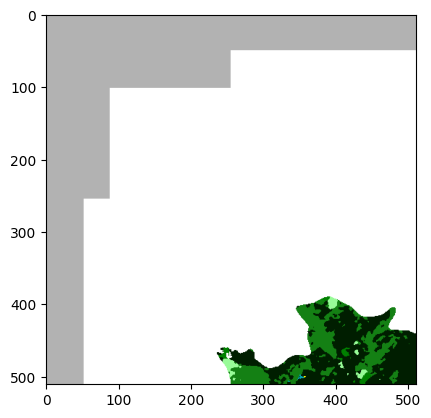

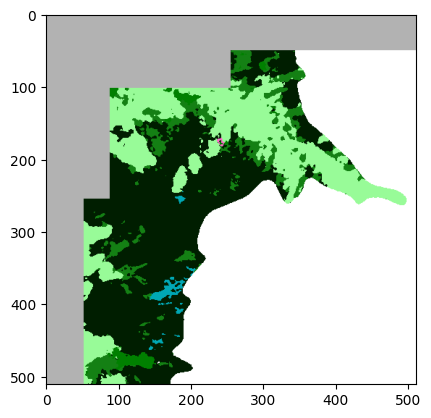

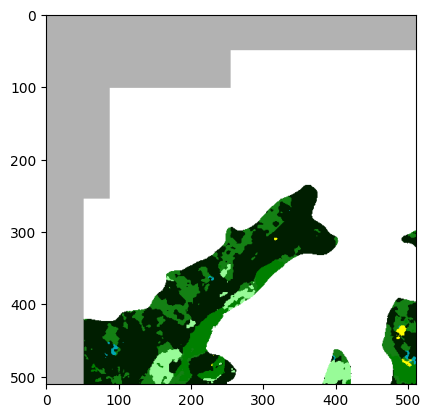

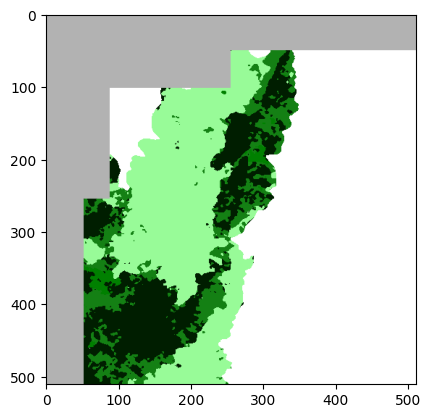

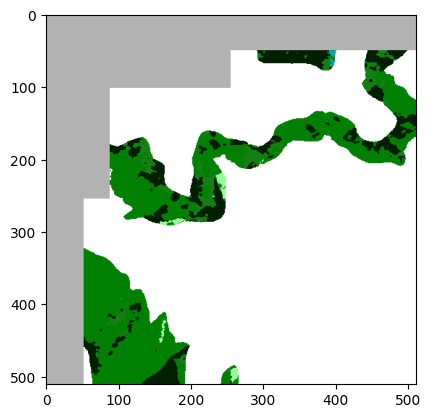

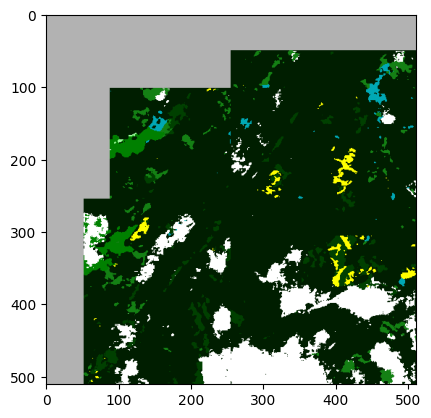

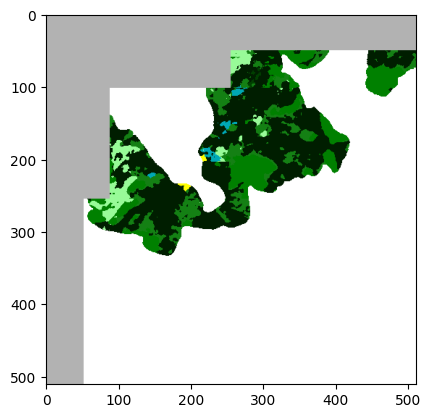

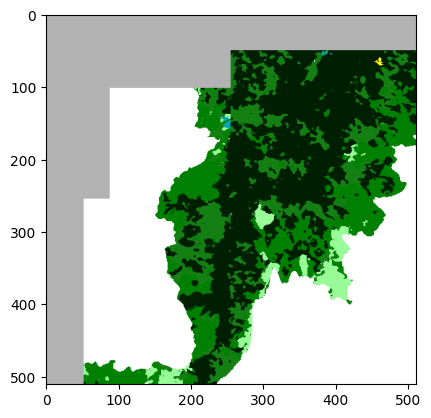

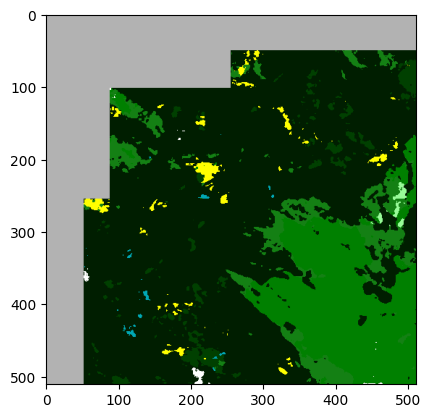

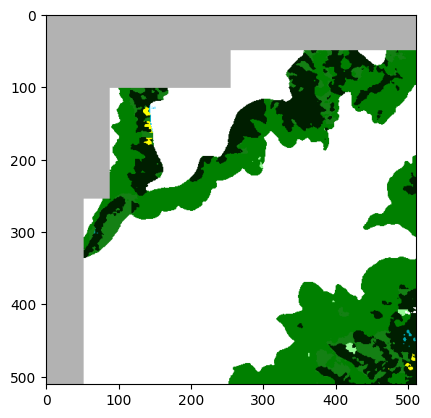

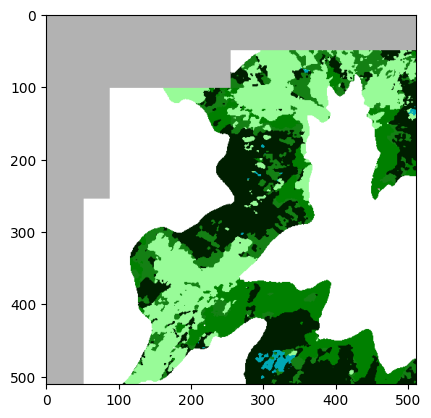

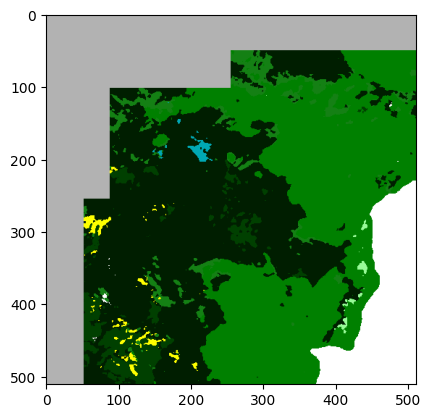

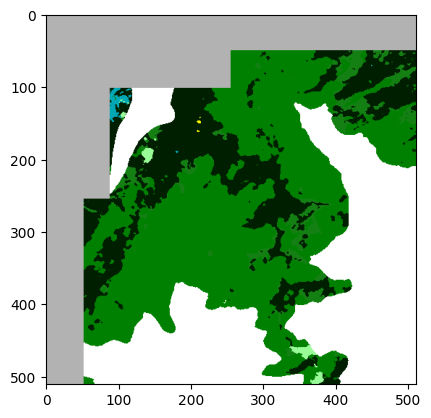

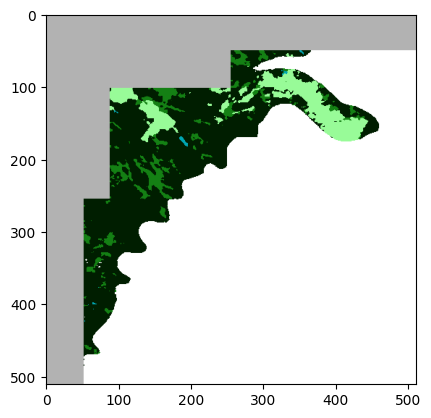

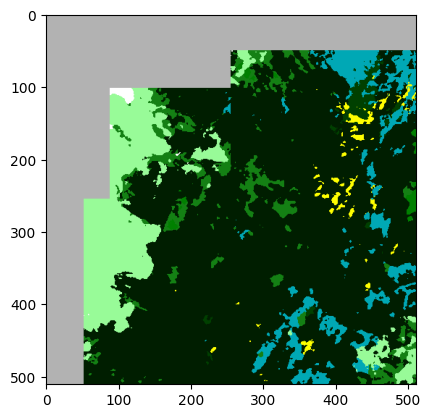

In [49]:
for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./inference_tile_{}.png'.format(id_), img)